# Modeler Starter Kit
This notebook will walk you through the entire challenge lifecycle, from fetching the training data, to training a model, to submitting your model for evaluation.

## Fetch Training Data
The following code will allow you download a previously fetched training dataset for this competition using the Spectral cli. 

The training dataset is a tabular parquet file, where each row represents a borrow event at the specified timestamp. 

Each row contains a timestamp and ethereum block number, the wallet address that initiated the borrow transaction, a list of features including borrower and market activity, and a binary target variable indicating if the borrower was liquidated within 30 days of the borrow event.

See our data dictionary for a full list of features, their types, and descriptions. **TODO: INSERT LINK HERE**

During testing and consumption you will be given all of these values aside from the target variable. Your model will be evaluated on the ability to predict the target variable for each sample in the test set.



In [15]:
#List available challenges
!spectral-cli  list-challenges  

Available challenges:
Credit Scoring: 0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939


In [16]:
# Download Training Data
!spectral-cli fetch-training-data 0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939

Failed to fetch the file from the official gateway. Trying another gateway...
112MiB [00:00, 1.19GiB/s]
Training dataset successfully fetched from the alternative gateway!


Examine a subset of the dataset

In [17]:
import duckdb
duckdb.query((f"""
select * from '{'0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939_training_data.parquet'}' limit 10
""")).df()

,borrow_block_number,borrow_timestamp,wallet_address,target,unique_borrow_protocol_count,unique_lending_protocol_count,total_collateral_eth,misc_available_borrows_eth,risk_factor,risk_factor_above_threshold_daily_count,...,total_balance_eth,withdraw_amount_sum_eth,borrow_amount_sum_eth,borrow_amount_avg_eth,borrow_count,repay_amount_sum_eth,repay_amount_avg_eth,repay_count,borrow_repay_diff_eth,withdraw_deposit_diff_If_positive_eth
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,0,1,44.479139,31.575270,0.000001,0.0,...,58.317987,0.0,0.000000,0.000000,0,0.0,0.0,0,0.000000,0.0
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,44.479139,31.418863,0.004953,0.0,...,58.317987,0.0,0.157110,0.157110,1,0.0,0.0,0,0.157110,0.0
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,44.479139,31.035236,0.017103,0.0,...,58.317987,0.0,0.543275,0.271637,2,0.0,0.0,0,0.543275,0.0
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,0,0,1,0.000767,0.000460,0.000001,0.0,...,0.000000,0.0,0.000000,0.000000,0,0.0,0.0,0,0.000000,0.0
4,7712572,1.557217e+09,0xbd9ed130a53cfafcf81502e4d35329a6c4d53410,0,0,1,0.010000,0.007500,0.000001,0.0,...,0.000000,0.0,0.000000,0.000000,0,0.0,0.0,0,0.000000,0.0
5,7715069,1.557250e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,44.488424,30.059852,0.048606,0.0,...,58.317987,0.0,1.543275,0.514425,3,0.0,0.0,0,1.543275,0.0
6,7715078,1.557251e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,44.430545,29.912079,0.052241,0.0,...,58.317987,0.0,1.543275,0.514425,4,0.0,0.0,0,1.543275,0.0
7,7715985,1.557263e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,51.316928,28.781848,0.088052,0.0,...,58.317987,0.0,2.749083,0.687271,5,0.0,0.0,0,2.749083,0.0
8,7716888,1.557276e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,58.791139,38.667542,0.081422,0.0,...,3.127926,0.0,3.320086,0.664017,6,0.0,0.0,0,3.320086,0.0
9,7717003,1.557277e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,60.268602,33.574491,0.221625,0.0,...,3.127926,0.0,9.247470,1.541245,7,0.0,0.0,0,9.247470,0.0


You may choose to use any subset of the data above to train your model. We guarantee availability of this data during the challenge lifespan.
You may also supplement this set with external data, however you will be responsible for hosting and serving this data during testing and consumption.

## EDA and Feature Engineering

You may use any tools you wish to explore the data and generate features. As an example we examine the max_risk_factor feature, look for potential outliers, consider dropping those samples, and examine correlated features

In [22]:
import pandas as pd
training_dataframe = duckdb.query((f"""
select * from '{'0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939_training_data.parquet'}'
""")).df()
training_dataframe['max_risk_factor'].describe()

count    4.316180e+05
mean     2.946256e+08
std      3.271465e+10
min      0.000000e+00
25%      4.379520e-01
50%      7.663844e-01
75%      9.154721e-01
max      3.633082e+12
Name: max_risk_factor, dtype: float64

The max value listed above is far greater than the majority of samples, and may be an outlier. A risk factor over one is uncommon, so a value this large could be due to a highly irregular onchain action, an error in data fetching, or an error dataset construction. 

We should examine samples with high values of this feature.

In [33]:
duckdb.query((f"""
select count(distinct(wallet_address)) as unusually_high_risk_factor_address from '{'0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939_training_data.parquet'}'
where max_risk_factor > 100
""")).df()

,unusually_high_risk_factor_address
0,61


There are 61 addresses with this unusually high value, let's remove all samples with a risk factor over 100 from training. 

In [34]:
training_dataframe = duckdb.query((f"""
select * from '{'0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939_training_data.parquet'}'
where max_risk_factor < 100
""")).df()
training_dataframe['max_risk_factor'].describe()

count    429835.000000
mean          0.806303
std           2.302598
min           0.000000
25%           0.434355
50%           0.764848
75%           0.913552
max          86.364163
Name: max_risk_factor, dtype: float64

A risk factor of 86 is still highly unusual, but we will leave it in for now as this is only an example.

It's always helpful to visualize data when getting acquainted, so let's examine a few features together. We'll look at the correlation between the withdraw_deposit_diff_If_positive_eth, withdraw_amount_sum_eth, and deposit_amount_sum_eth features.


These defi features represent the total amount of eth withdrawn, deposited, and the difference between the two.

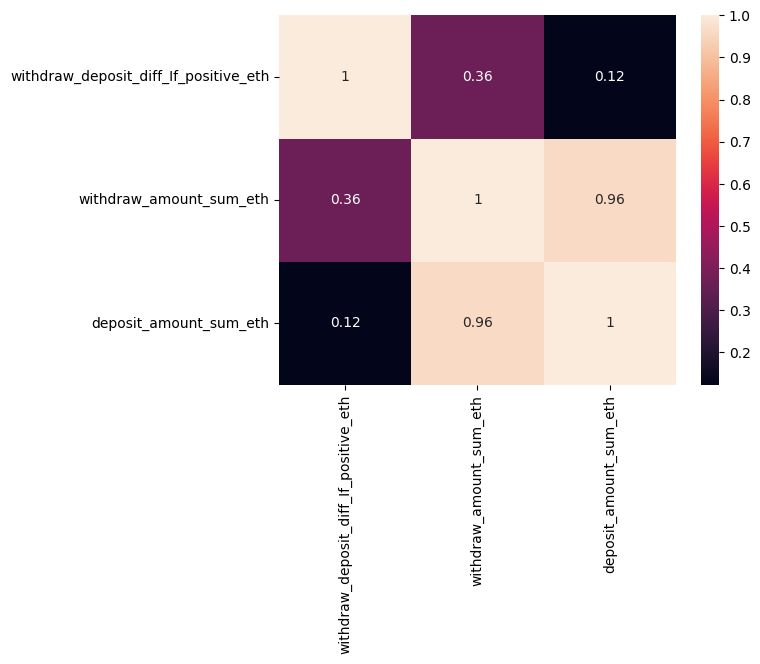

In [38]:
import matplotlib.pyplot as mp 
import seaborn as sb 
dataplot = sb.heatmap(training_dataframe[['withdraw_deposit_diff_If_positive_eth', 'withdraw_amount_sum_eth', 'deposit_amount_sum_eth' ]].corr(), annot=True) 
mp.show() 

These features represent actions on opposite ends of the lending lifecycle, so we could reasonably expect there to be some correlation for many samples.

withdraw_amount_sum_eth and deposit_amount_sum_eth are highly correlated, so we'll move to drop withdraw_amount_sum_eth from our training set. In practice it would be beneficial to examine the correlation between other features and understand why some of these may be correlated or not.  

In [41]:
training_dataframe = duckdb.query((f"""
select * from '{'0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939_training_data.parquet'}'
where max_risk_factor < 100
""")).df().drop(columns=['withdraw_amount_sum_eth'], inplace=False)

For this example we'll conclude our eda, and move to modelling. During the challenge you should spend time exploring the data and generating features.There is no shortage of exciting onchain activity that could be used to generate features, and we encourage you to be creative. 


Features derived from activity on other lending protocols, other chains, non-fungibile token value, and decentralized exchanges positions have all been proven to be relevant in our previous work. 

## Modeling

### Train an example logistic regression model using the datasets above

This is purely an example, in no way is this a "good" model. It is simply a demonstration of how to train a model using the datasets above. We also don't care much about accuracy alone, only a simple example.